In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Define constants
COUNT_THRESHOLD = 5  # Count threshold for labeling a node as a leaf
MAX_DEPTH = 3  # Maximum depth for the decision tree

In [1]:
def calculate_gini(data):
    cols = [row[-1] for row in data]
    tcol = len(cols)
    col_counts = {col: cols.count(col) for col in set(cols)}
    gini = 1 - sum((count/tcol)**2 for count in col_counts.values())
    return gini 


In [2]:
def split_data(data, attribute_index, value):
    return [row for row in data if row[attribute_index] == value]


In [12]:
def gini_gain(data, attribute_index):
    p_gini = calculate_gini(data)
    total = len(data)
    names = set(row[attribute_index] for row in data)
    w_gini = 0
    for name in names:
        subset = split_data(data, attribute_index, name)
        sw_gini = calculate_gini(subset)
        w_gini += (len(subset)/total)*sw_gini
    gini_gain = p_gini-w_gini
    return gini_gain


In [6]:
def build_tree(data, attributes, depth=0):
    if len(set(row[-1] for row in data)) == 1 or depth == MAX_DEPTH or len(data) < COUNT_THRESHOLD or not attributes:
        return max(set(row[-1] for row in data), key=[row[-1] for row in data].count)
    best_attribute = max(attributes, key=lambda attr: gini_gain(data, attr))
    tree = {best_attribute: {}}
    attributes = [attr for attr in attributes if attr != best_attribute]
    values = set(row[best_attribute] for row in data)
    for value in values:
        subset = split_data(data, best_attribute, value)
        tree[best_attribute][value] = build_tree(subset, attributes, depth + 1)

    return tree


In [7]:
def predict(tree, instance):
    if not isinstance(tree, dict):  # If leaf node, return the label
        return tree

    attribute = list(tree.keys())[0]  # Current decision attribute
    value = instance.get(attribute)
    subtree = tree[attribute].get(value, None)

    if subtree is None:
        return None  # Handle unseen values
    return predict(subtree, instance)


In [8]:
# Load the dataset from the CSV file
df = pd.read_csv("car_evaluation.csv")

# Define a mapping for the categorical values to numerical values
value_mappings = {
    'buying': {'vhigh': 3, 'high': 2, 'med': 1, 'low': 0},
    'maint': {'vhigh': 3, 'high': 2, 'med': 1, 'low': 0},
    'doors': {'2': 0, '3': 1, '4': 2, '5more': 3},
    'persons': {'2': 0, '4': 1, 'more': 2},
    'lug_boot': {'small': 0, 'med': 1, 'big': 2},
    'safety': {'low': 0, 'med': 1, 'high': 2}
}

# Apply the mappings to the dataset
for column, mapping in value_mappings.items():
    df[column] = df[column].map(mapping)

# Extract the features and target
X = df.drop(columns=['class'])  # Drop the target column
y = df['class'].map({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})  # Map target to numerical values

# Convert DataFrame to list for the decision tree
data = df.values.tolist()
attributes = list(range(len(X.columns)))  # Indexes of the attributes (buying, maint, etc.)
attribute_names = list(X.columns)  # Get the actual attribute names


In [13]:
# Build the decision tree
tree = build_tree(data, attributes)
print("Decision Tree:", tree)

Decision Tree: {5: {0: 'unacc', 1: {3: {0: 'unacc', 1: {0: {0: 'acc', 1: 'acc', 2: 'unacc', 3: 'unacc'}}, 2: {4: {0: 'unacc', 1: 'acc', 2: 'acc'}}}}, 2: {3: {0: 'unacc', 1: {0: {0: 'vgood', 1: 'acc', 2: 'acc', 3: 'unacc'}}, 2: {0: {0: 'vgood', 1: 'acc', 2: 'acc', 3: 'unacc'}}}}}}


<Figure size 1400x800 with 0 Axes>

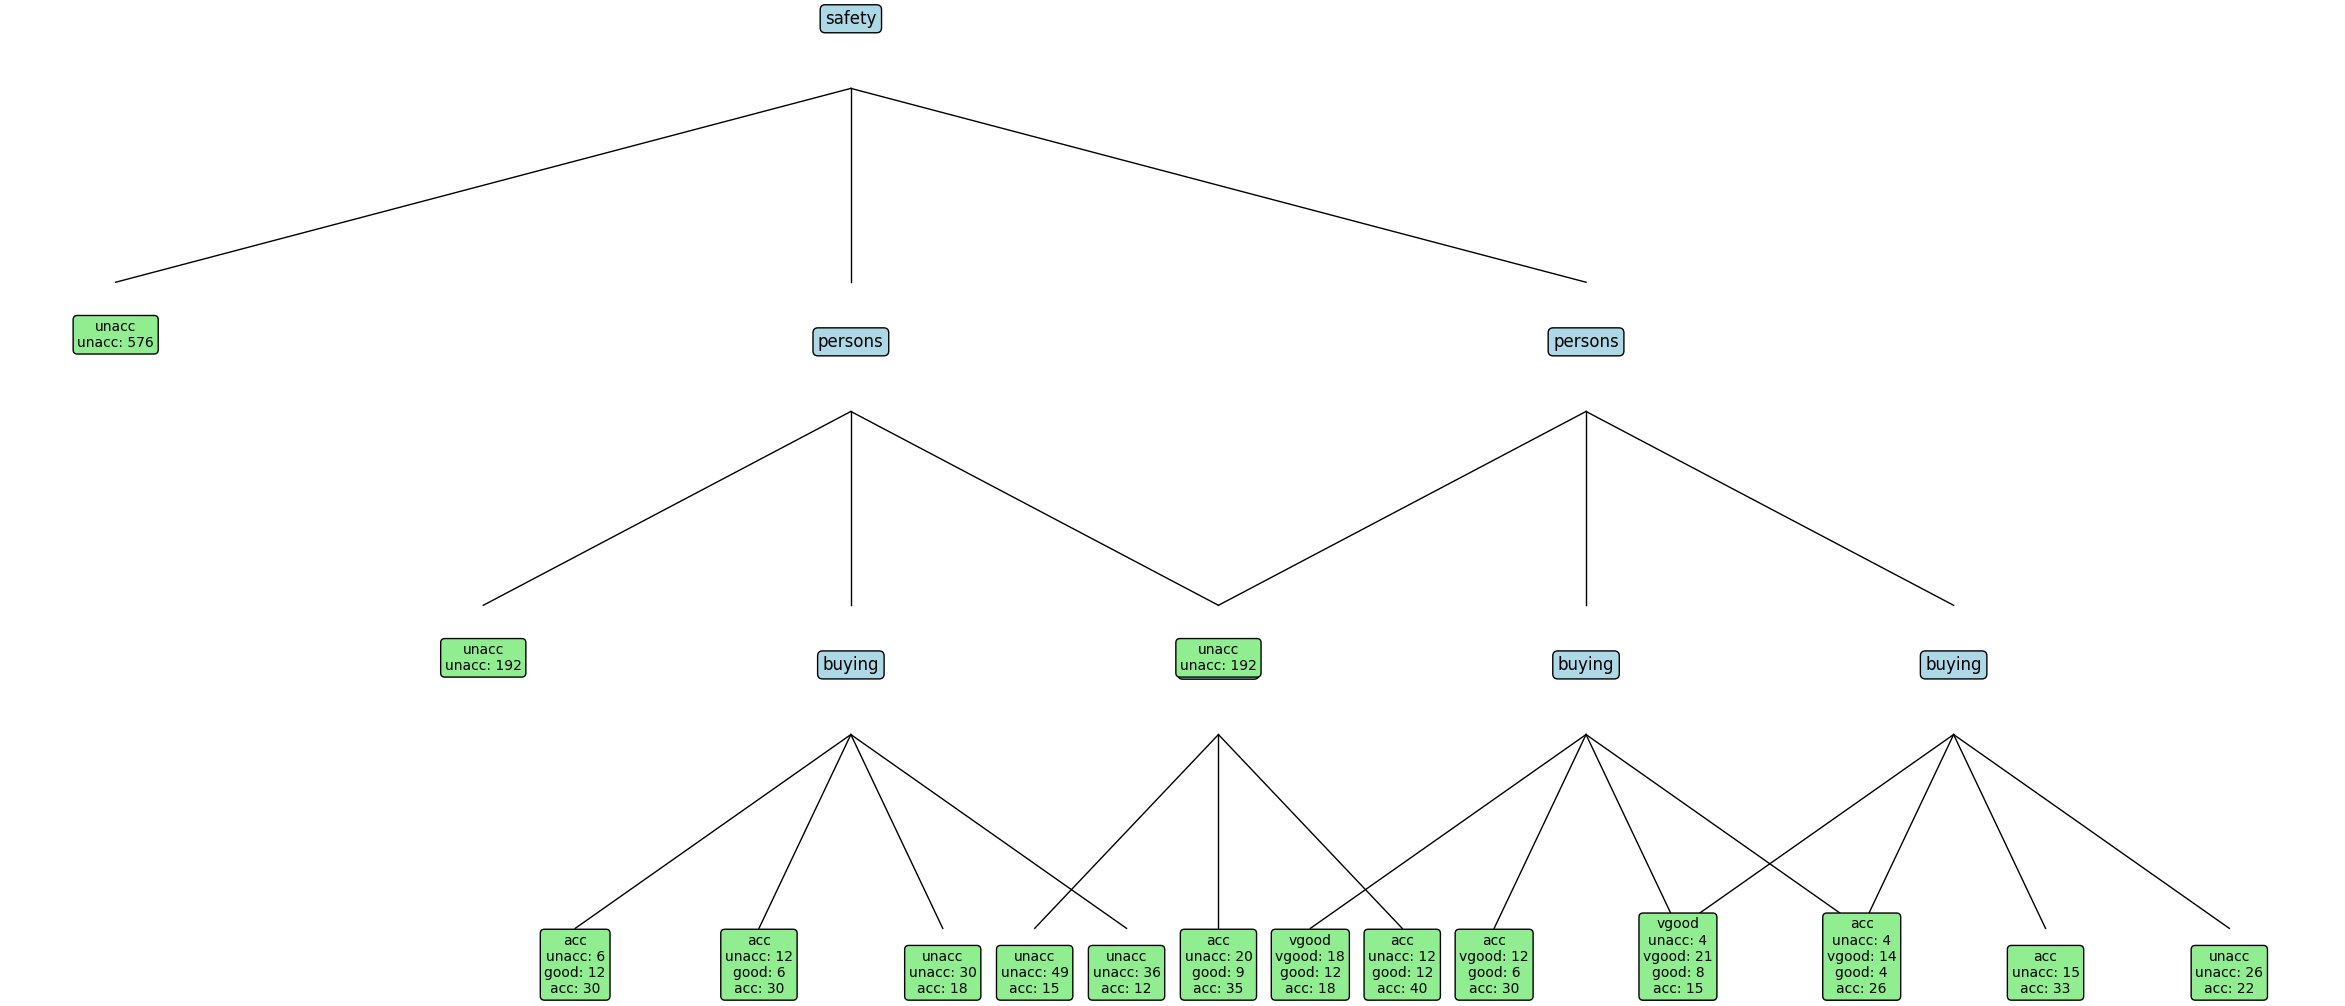

In [24]:

# Visualize the decision tree
def plot_tree(tree, depth=0, x_offset=0.5, y_offset=1.0, x_gap=0.25, ax=None, data=None, attribute_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(30, 12))
        ax.axis('off')  # Turn off the axes

    # If the tree is a leaf node, plot the label and counts
    if not isinstance(tree, dict):
        # Count the occurrences of each label in the current leaf data subset
        label_counts = {label: sum(1 for row in data if row[-1] == label) for label in set(row[-1] for row in data)}
        # Format the label text to include counts of each class
        label_text = f"{tree}\n" + "\n".join([f"{label}: {count}" for label, count in label_counts.items()])
        ax.text(x_offset, y_offset, label_text, fontsize=10, ha='center', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", edgecolor="black"))
        return

    # Get the current decision attribute name
    root = list(tree.keys())[0]
    attribute_name = attribute_names[root]  # Map the index to the attribute name
    ax.text(x_offset, y_offset, f"{attribute_name}", fontsize=12, ha='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", edgecolor="black"))

    # Recursively plot child nodes
    num_children = len(tree[root])
    for i, (value, subtree) in enumerate(tree[root].items()):
        child_x = x_offset + (i - (num_children - 1) / 2) * x_gap  # Calculate child x position
        child_y = y_offset - 0.1  # Shift vertically for the child nodes

        # Draw a line to the child node
        ax.plot([x_offset, child_x], [y_offset - 0.02, child_y + 0.02], 'k-', lw=1)

        # Recursively call plot_tree for the child node, passing the subset of data that corresponds to the child
        subset = split_data(data, root, value)  # Get the subset of data for this child
        plot_tree(subtree, depth + 1, child_x, child_y, x_gap / 2, ax=ax, data=subset, attribute_names=attribute_names)

    if depth == 0:  # Show the plot only at the top level
        plt.show()



# Visualize the decision tree
plt.figure(figsize=(14, 8))
plot_tree(tree, data=data, attribute_names=attribute_names)

In [18]:
# Test prediction
test_instance = {0: 1, 1: 2}  # Middle-aged with High income
prediction = predict(tree, test_instance)
print("\nPrediction for test instance:", "Yes" if prediction == 1 else "No")


Prediction for test instance: No
